In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
with open('../processed_data/model_genes.txt', 'rb') as reader:
    selected_genes = set([s.strip() for s in reader.readlines()])

In [4]:
f = fns[0]
tissue = f.split('-')[0]
df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)    
id2gene = [str(s) for s in df_exp.columns if s.split('.')[0] in selected_genes]
assert(len(id2gene) == len(selected_genes))

In [5]:
len(id2gene)

11890

In [6]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [7]:
len(id2tissue)

7051

In [10]:
import numpy as np
data = np.vstack(data)

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf


In [12]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
            h_in = h_out
            #
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_in = tf.layers.batch_normalization(h_in, training=is_train, name = 'h%02d/batch_norm' % i)
                h_in = tf.layers.dropout(h_in, rate=0.5, training=is_train)
            #h_in = tf.nn.relu(h_in) 
            h_in = tf.nn.tanh(h_in)   
    return h_out

In [13]:
num_gene = len(id2gene)

In [14]:
data.shape

(7051, 11890)

In [15]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :].astype('float32')
test_data = data[ind_test, :].astype('float32')

num_sample = train_data.shape[0]

In [17]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 512, whiten=False)
clf.fit(train_data)

V0 = clf.components_ / np.linalg.norm(clf.components_.T)
U0 = clf.components_.T * np.linalg.norm(clf.components_.T)

In [55]:
beta1 = 0.9

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'l1_penalty')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')
    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    ## net for inference
    theta_mat = [512, num_gene]
    
    l1_scaled = l1_penalty * (0.5 * float(num_sample) / float(theta_mat[0]) ) 
    
    
    #w0_tf = tf.get_variable('w0_tf', initializer=U0)
    #w1_tf = tf.get_variable('w1_tf', initializer=V0)
    w0_tf = tf.get_variable('w0_tf', [theta_mat[1], theta_mat[0]])
    w1_tf = tf.get_variable('w1_tf', [theta_mat[0], theta_mat[1]])
    
    #w1n_tf = w1_tf / tf.stop_gradient(tf.linalg.norm(w1_tf))
    w1n_tf = w1_tf / tf.linalg.norm(w1_tf)
    
        
    h0 = tf.matmul(inputs, w0_tf, name = 'h0')
    logit_rec = tf.matmul(h0, w1n_tf, name = 'h1')
    
    rec_loss_l2 = tf.reduce_mean(tf.square(logit_rec - inputs))
    
    ## net for training, data loaded on GPU to save computation
    inputs_train = tf.constant(train_data, name = 'input_training')
    inputs_train += tf.random.normal(tf.shape(inputs_train), mean=0.0, stddev=.1)
    
    h0_train = tf.matmul(inputs_train, w0_tf, name = 'h0_train')
    logit_rec_train = tf.matmul(h0_train, w1n_tf, name = 'h1_train')
    
    rec_loss_l2_train = tf.reduce_sum(tf.square(logit_rec_train - inputs_train))
    
    d_loss = rec_loss_l2_train# + l1_scaled * tf.reduce_mean(tf.abs(w0_tf))
    
    dw0, dw1 = tf.gradients(d_loss, [w0_tf, w1_tf])
    #dw1 = tf.gradients(d_loss, w1_tf)
    
    w0t_tf = w0_tf - d_lrd * dw0
    w0t_tf = tf.nn.relu(w0t_tf - l1_scaled * d_lrd) - tf.nn.relu(-w0t_tf - l1_scaled * d_lrd)
    
    w1t_tf = w1_tf - d_lrd * dw1
    
    update_w0_op = w0_tf.assign(w0t_tf)
    update_w1_op = w1_tf.assign(w1t_tf)

In [56]:
sess = tf.Session()

In [57]:
sess.run(tf.global_variables_initializer())

In [58]:
sess.run(dw0).max()

127.20564

In [ ]:
iter_counter = 0
errD0, errD1, D_count = 0.0, 0.0, 0.0

num_batch = num_sample

for idx in range(2000):
    lrd = 1e-3 / np.sqrt(idx * 0.005 + 1.0)
    #l1_val = 1000.0
    l1_val = .1
        
    # updates the discriminator
    
    feed_dict={is_training:True,
               l1_penalty: l1_val,
               d_lrd: lrd,
                }
    sess.run(update_w0_op, feed_dict = {l1_penalty: l1_val, d_lrd: lrd})
    sess.run(update_w1_op, feed_dict = {l1_penalty: l1_val, d_lrd: lrd})
    
    val0, val1 = sess.run([d_loss, rec_loss_l2_train], feed_dict=feed_dict)

    errD0 += val0
    errD1 += val1
    
    D_count += 1.0
        
    
    if idx % 100 == 0:
        errD0 = errD0 / D_count
        errD1 = errD1 / D_count

        feed_dict={inputs: test_data, is_training:False,}            

        test_errD1 = sess.run(rec_loss_l2, feed_dict=feed_dict)

        msr = "iter: %4d, full_loss: %.4f, train_loss: %.4f, test_loss: %.4f" \
            % (idx, errD0, errD1, test_errD1)
        print(msr)
        errD0, errD1, D_count = 0.0, 0.0, 0.0


In [43]:
w0_val.dtype

dtype('float32')

In [65]:
w0_val = sess.run(w0_tf)

In [66]:
np.sum(np.abs(w0_val) < 5e-7) / float(w0_val.size)

0.9382930771656854

In [67]:
np.mean(np.abs(w0_val))

0.003464868

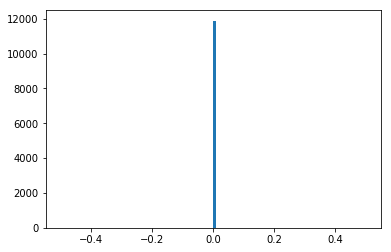

In [68]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 1], bins = 100)
plt.show()

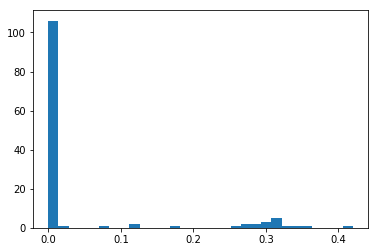

In [69]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [70]:
np.abs(w0_val[:, 0]).max()

0.0

In [71]:
from statsmodels import robust

In [72]:
for i in range(100):
    thre = (0.001 * np.abs(w0_val[:, i])).max()
    #thre = 3.0 * w0_val[:, i].std()
    #thre = 1.8 * robust.mad(w0_val[:, i])
    #thre = 1e-5
    print i, np.sum(np.abs(w0_val[:, i]) > thre ), thre, np.sum(np.abs(w0_val[:, i]) > 100. * thre ), np.max(np.abs(w0_val[:, i]))

0 0 0.0 0 0.0
1 0 0.0 0 0.0
2 0 0.0 0 0.0
3 0 0.0 0 0.0
4 0 0.0 0 0.0
5 0 0.0 0 0.0
6 0 0.0 0 0.0
7 0 0.0 0 0.0
8 0 0.0 0 0.0
9 0 0.0 0 0.0
10 0 0.0 0 0.0
11 0 0.0 0 0.0
12 0 0.0 0 0.0
13 4466 0.0003013979 2722 0.3013979
14 0 0.0 0 0.0
15 0 0.0 0 0.0
16 0 0.0 0 0.0
17 0 0.0 0 0.0
18 0 0.0 0 0.0
19 0 0.0 0 0.0
20 3111 0.00031121392 1808 0.3112139
21 0 0.0 0 0.0
22 0 0.0 0 0.0
23 0 0.0 0 0.0
24 0 0.0 0 0.0
25 0 0.0 0 0.0
26 0 0.0 0 0.0
27 0 0.0 0 0.0
28 0 0.0 0 0.0
29 0 0.0 0 0.0
30 2 2.251814e-05 2 0.022518137
31 0 0.0 0 0.0
32 0 0.0 0 0.0
33 0 0.0 0 0.0
34 1971 0.00028425307 1156 0.28425306
35 0 0.0 0 0.0
36 0 0.0 0 0.0
37 0 0.0 0 0.0
38 5253 0.0003144066 3320 0.3144066
39 0 0.0 0 0.0
40 0 0.0 0 0.0
41 0 0.0 0 0.0
42 0 0.0 0 0.0
43 0 0.0 0 0.0
44 4 7.122005e-05 2 0.07122005
45 4471 0.0002937505 2837 0.29375046
46 0 0.0 0 0.0
47 0 0.0 0 0.0
48 0 0.0 0 0.0
49 0 0.0 0 0.0
50 0 0.0 0 0.0
51 0 0.0 0 0.0
52 0 0.0 0 0.0
53 0 0.0 0 0.0
54 0 0.0 0 0.0
55 0 0.0 0 0.0
56 0 0.0 0 0.0
57 0 0.0 0 0.

In [74]:
gene_mat = np.zeros(w0_val.shape)

for i in range(512):
    thre = (0.001 * np.abs(w0_val[:, i])).max()
    gene_mat[:, i] = np.abs(w0_val[:, i]) > thre

In [75]:
gene_mat.sum(axis = 1)

array([ 1.,  5.,  8., ...,  8., 11.,  7.])

/data1/users/hclee/hclee/python2/local/lib/python2.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

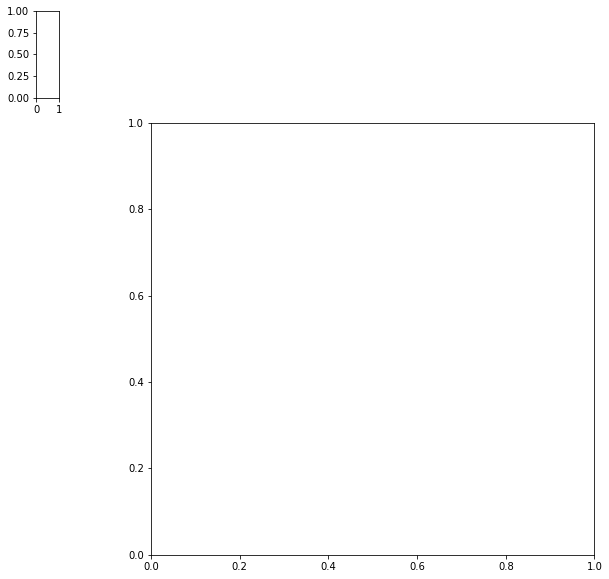

In [111]:
import seaborn.apionly as sns

sns.clustermap(w0_val, cmap = 'RdBu_r')
plt.show()

In [ ]:
sns.clustermap(test_data.dot(w0_val), cmap = 'RdBu_r')
plt.show()

In [77]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [81]:
i = 19
thre = (0.001 * np.abs(w0_val[:, i])).max()

for i in np.where(np.abs(w0_val[:, i]) > thre)[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

CDK11B
NPPA
NPPB
TRIM63
ENSG00000203827
LOR
NEK7
TNNI1
ACTA1
CALML5
TIMM23B
TNNI2
TAF10
MYBPC3
KRT2
KRT1
DCD
MUCL1
MYBPC1
NPIPB5
ATP2A1
NPIPB11
SULT1A4
NPIPB12
MYLPF
LDHD
MYH1
MYH2
KRT14
DDX5
KIAA1468
MBP
KRTDAP
SBSN
TBCB
LGALS7B
CKM
MYBPC2
TNNI3
TPO
TRMT61B
SPTBN1
EIF5B
NEB
KLHL41
MYL1
CENPB
KIF3B
TNNC2
MAP4
CCT5
LY6G6C
MYL7
EPHB4
ADHFE1
TG
CBWD5
CBWD3
IDNK


In [49]:
feed_dict={inputs: test_data, 
           is_training:False,
           l1_penalty: l1_val,
           #noise_level: 0.05, 
           d_lrd: lrd,
            }

rec_val = sess.run(logit_rec, feed_dict=feed_dict)

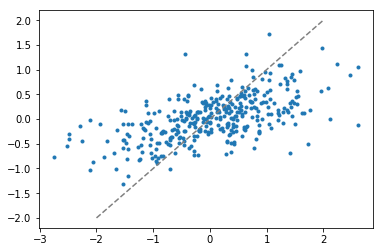

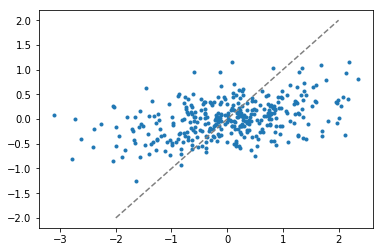

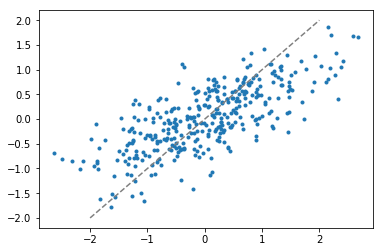

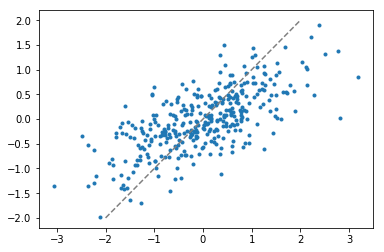

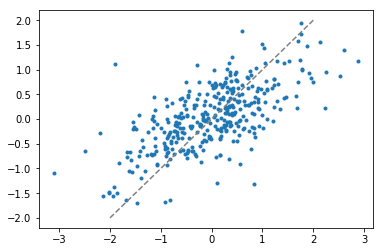

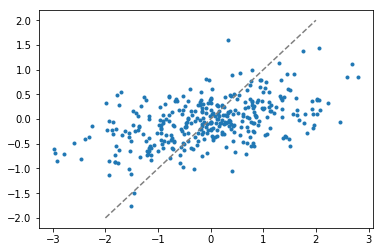

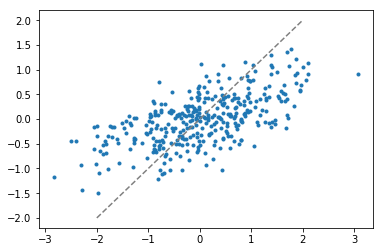

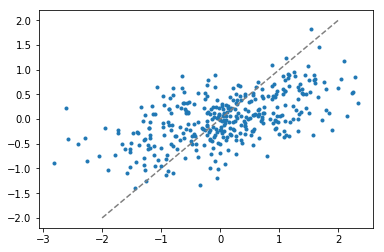

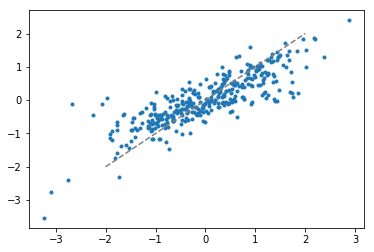

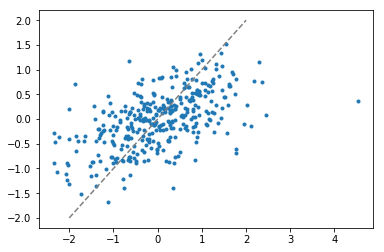

In [50]:
for i in range(0, 100, 10):
    plt.plot(test_data[:, i], rec_val[:, i], '.')
    plt.plot([-2.0, 2.0], [-2.0, 2.0], '--', color = 'gray')
    plt.show()

In [18]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 512)

In [19]:
clf.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=512, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
clf.explained_variance_ratio_.sum()

0.48809826

In [21]:
test_rec = clf.inverse_transform(clf.transform(test_data))

In [22]:
np.mean((test_rec - test_data) ** 2)

0.6111599

In [23]:
train_rec = clf.inverse_transform(clf.transform(train_data))
np.mean((train_rec - train_data) ** 2)

0.5089995